# Imperfect testing model

In this notebook, we relax the perfect testing assumption by accounting for the possibility of false positives and negatives in antigen testing. To do this, we incorporate two additional parameters into our model:

- The true positive rate (antigen test sensitivity)
- The true negative rate (antigen test specificity)

These are parameters are estimated within the model, and are pinned down by informative priors calibrated with data from the [Joint PHE Porton Down & University of Oxford SARS-CoV-2 test development and validation cell](https://www.ox.ac.uk/sites/files/oxford/media_wysiwyg/UK%20evaluation_PHE%20Porton%20Down%20%20University%20of%20Oxford_final.pdf). 

In [1]:
import time
import arviz
import numpy as np
import pandas as pd
import pystan

In [2]:
# Parameters
P = 10
N = 3*(10 ** 4)
SEED = 1729

In [3]:
# Ground truth
np.random.seed(SEED)
true_transmission_rate = np.random.beta(2, 10, P)
true_occurrence_rate = np.random.beta(2, 10, P)
base_rate = np.random.beta(2, 10, 1)

t_i = np.random.beta(8, 2, 1)  # Prob(tested | infected)
t_not_i = np.random.beta(2, 20, 1)  # Prob(tested | not-infected)
true_gamma = np.array([t_i, t_not_i])

test_sensitivity = np.random.beta(4, 3, 1)  # True positive rate
test_specificity = np.random.beta(50, 2, 1)  # True negative rate
true_lambda = np.array([test_sensitivity, test_specificity])

In [4]:
# Simulate data
data = {}
for p in range(P):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N)
    transmission = occurrence * np.random.binomial(1, true_transmission_rate[p], N)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission

data['T0'] = np.random.binomial(1, base_rate, N)
X = pd.DataFrame(data)
z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
y = (z > 0).astype(int)

# Resampling using testing probabilites conditional on infected
tested = y*np.random.binomial(1, true_gamma[0], N) + (1-y)*np.random.binomial(1, true_gamma[1], N)
y = y[tested == 1]
X_survey = X[tested == 0].reset_index()
X = X[tested == 1].reset_index()

N = X.shape[0]
NA = X_survey.shape[0]

# Introducing false positives and negatives
y = y*np.random.binomial(1, true_lambda[0], N) + (1-y)*np.random.binomial(1, (1-true_lambda[1]), N)

X = X.loc[:, X.columns.str.startswith('O')]
X_survey = X_survey.loc[:, X_survey.columns.str.startswith('O')]
X.info()
X_survey.info()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8193 entries, 0 to 8192
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   O1      8193 non-null   int64
 1   O2      8193 non-null   int64
 2   O3      8193 non-null   int64
 3   O4      8193 non-null   int64
 4   O5      8193 non-null   int64
 5   O6      8193 non-null   int64
 6   O7      8193 non-null   int64
 7   O8      8193 non-null   int64
 8   O9      8193 non-null   int64
 9   O10     8193 non-null   int64
dtypes: int64(10)
memory usage: 640.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21807 entries, 0 to 21806
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   O1      21807 non-null  int64
 1   O2      21807 non-null  int64
 2   O3      21807 non-null  int64
 3   O4      21807 non-null  int64
 4   O5      21807 non-null  int64
 5   O6      21807 non-null  int64
 6   O7      21807 non-null  int64
 7   O8 

In [5]:
# Create model
sm = pystan.StanModel(model_name='tt_mod', model_code="""
data {
  int<lower=0> N;                            // number of test observations
  int<lower=0> NA;                           // number of survey observations
  int<lower=0> P;                            // number of places
  int<lower=0, upper=1> X[N,P];              // activity occurrences of tested individuals
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
  int<lower=0, upper=1> survey[NA,P];        // activity occurrences of surveyed individuals
  real<lower=0, upper=1> mean_lambda[2];     // mean TP and TN test rates (for strong priors on tests)
  real<lower=0> se_lambda[2];                // standard error of test rates (for strong priors on tests)
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> rho;                // underlying risk
  real<lower=0, upper=1> gamma[2];           // Testing rates, given infected status [T|I , T|!I]
  real<lower=0, upper=1> lambda[2];          // True positive and true negative rates of tests [TP,TN]
}
model {
  // Precomputation
  real log1m_theta[P];
  real log1m_rho;
  real log_gamma[2];
  real log1m_gamma[2];
  real log_lambda[2];
  real log1m_lambda[2];
  real a_lambda[2];
  real b_lambda[2];
  
  for (p in 1:P) {
    log1m_theta[p] = log1m(theta[p]);
  }
  for(i in 1:2){
    log_gamma[i] = log(gamma[i]);
    log1m_gamma[i] = log1m(gamma[i]);
    log_lambda[i] = log(lambda[i]);
    log1m_lambda[i] = log1m(lambda[i]);
    
    a_lambda[i] = (((1-mean_lambda[i])/se_lambda[i]^2)-(1/mean_lambda[i]))*(mean_lambda[i]^2);
    b_lambda[i] = a_lambda[i]*((1/mean_lambda[i])-1);
  }
  
  log1m_rho = log1m(rho);
  
  // Priors
  theta ~ uniform(0, 1);
  rho ~ uniform(0, 1);
  gamma ~ uniform(0, 1);
  lambda[1] ~ beta(a_lambda[1], b_lambda[1]);
  lambda[2] ~ beta(a_lambda[2], b_lambda[2]);

  // Likelihood
  for (n in 1:NA) {
    real s = 0.0;
    for (p in 1:P) {
      if (survey[n,p] == 1) {
        s += log1m_theta[p];
      }
    }
    s += log1m_rho;
    target += log_sum_exp((log1m_exp(s)+log1m_gamma[1]), (s+log1m_gamma[2]));
  }
  
  for (n in 1:N) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        s += log1m_theta[p];
      }
    }
    s += log1m_rho;
    
    if (y[n] == 1) {
      target += log_sum_exp((log1m_exp(s) + log_gamma[1] + log_lambda[1]), (s + log_gamma[2] + log1m_lambda[2]));
    } 
    else {
      target += log_sum_exp((s + log_gamma[2] + log_lambda[2]), (log1m_exp(s) + log_gamma[1] + log1m_lambda[1]));
    }
  }
}
""")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL tt_mod_a506dfaa99248af72a3a715b770fb8f8 NOW.


### Note:
The means and standard error estimates used to create strong priors for antigen test accuracy are those reported by the [Joint PHE Porton Down & University of Oxford SARS-CoV-2 test development and validation cell](https://www.ox.ac.uk/sites/files/oxford/media_wysiwyg/UK%20evaluation_PHE%20Porton%20Down%20%20University%20of%20Oxford_final.pdf) 

In [6]:
# Set antigen test mean and std. error for TP and TN rates (for strong priors)

# True positive
mean_tp = 0.73000
se_tp = 0.04133

# True negative
mean_tn = 0.99680
se_tn = 0.00066

mean_rates = np.array([mean_tp, mean_tn])
se_rates = np.array([se_tp, se_tn])

In [7]:
# Set NUTS parameters
nuts_samples = 1000
nuts_burnin = 500
nuts_chains = 16

In [8]:
# Fit model
start = time.time()
model_data = {'N': N, 'NA': NA, 'P': P, 'X': X.to_numpy(),
              'y': y.to_numpy(), 'survey': X_survey.to_numpy(), 
              'mean_lambda':mean_rates, 'se_lambda':se_rates }
fit = sm.sampling(
    data=model_data,
    iter=nuts_samples,
    warmup=nuts_burnin,
    chains=nuts_chains
)
print(f"{time.time() - start:.02f} seconds elapsed")

2550.89 seconds elapsed


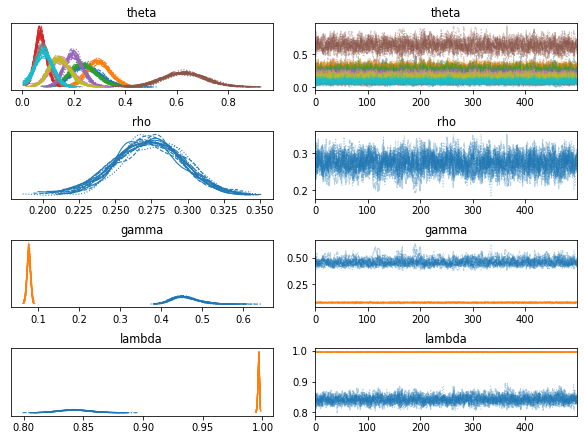

In [9]:
# Evaluate fit with test and trace resample
arviz.plot_trace(fit, figsize=(8, 6));

In [10]:
# View results
print("Inference on fitted model:")
print(fit)
print('')
print('Ground truth:')
print('Setting-specific transmission rates: ', true_transmission_rate)
print('Base rate: ', base_rate)
print('Testing rates: ', true_gamma)
print('True positive and negative rates: ', true_lambda)

Inference on fitted model:
Inference for Stan model: tt_mod_a506dfaa99248af72a3a715b770fb8f8.
16 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=8000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]    0.25  9.2e-4   0.06   0.15   0.21   0.25   0.29   0.37   3824    1.0
theta[2]     0.3  9.3e-4   0.05   0.21   0.27    0.3   0.33   0.39   2331   1.01
theta[3]    0.24  8.7e-4   0.05   0.14    0.2   0.24   0.27   0.35   3624    1.0
theta[4]    0.07  3.1e-4   0.02   0.03   0.06   0.07   0.09   0.12   5054    1.0
theta[5]     0.2  6.9e-4   0.04   0.13   0.18    0.2   0.22   0.28   2721    1.0
theta[6]    0.63  1.9e-3   0.08   0.48   0.58   0.63   0.69    0.8   1805   1.01
theta[7]    0.15  6.5e-4   0.04   0.07   0.12   0.15   0.18   0.24   4439    1.0
theta[8]    0.08  4.1e-4   0.03   0.02   0.06   0.08    0.1   0.15   5559    1.0
theta[9]    0.15  5.7e-4   0.04   0.07   0.12   0.14   0.17 